In [10]:
import json
import os
from collections import Counter
from transformers import CLIPProcessor, CLIPModel


photo_path = './photos'
root_path = './'

def gather_photos(label: str, no_captions: bool = False):
    """
    takes the label (category of images to fetch) and filters photos.json for images with that label
    filters for images that 
    returns: list of photo objects (photo_id, label, caption, etc.)
    """ 
    with open(os.path.join(root_path, 'photos.json'), 'r') as file:
        all_photos = []
        for line in file:
            line = line.rstrip()
            try:
                photo_record = json.loads(line)
                # filers for only ones wiht captions by default
                has_captions = len(photo_record['caption']) > 0 or no_captions 
                if photo_record['label'] == label and has_captions:
                    all_photos.append(photo_record)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e} at line: {line}")
        return all_photos
    
all_photos = gather_photos('food')

# summary statistics
photo_count = len(all_photos)
unique_business_count = len(set(photo['business_id'] for photo in all_photos))
labels_count = Counter(photo['label'] for photo in all_photos)
captions_count = Counter(len(photo['caption'].split()) for photo in all_photos if photo['caption'])

print(f"Total number of photos: {photo_count}")
print(f"Number of unique businesses: {unique_business_count}")
print(f"Photos per label: {dict(labels_count)}")
print(f"distribution of caption length: {captions_count}")


Total number of photos: 55331
Number of unique businesses: 16879
Photos per label: {'food': 55331}
distribution of caption length: Counter({2: 12674, 3: 10459, 4: 6303, 5: 4203, 1: 4108, 6: 3153, 7: 2420, 8: 1932, 9: 1486, 10: 1243, 11: 1056, 12: 975, 13: 810, 14: 669, 16: 554, 18: 541, 15: 522, 17: 444, 19: 417, 20: 349, 21: 301, 22: 217, 23: 184, 24: 112, 25: 82, 27: 54, 26: 45, 28: 10, 29: 7, 32: 1})


In [2]:
print(all_photos[0])

{'photo_id': 'pve7D6NUrafHW3EAORubyw', 'business_id': 'SZU9c8V2GuREDN5KgyHFJw', 'caption': 'Shrimp scampi', 'label': 'food'}


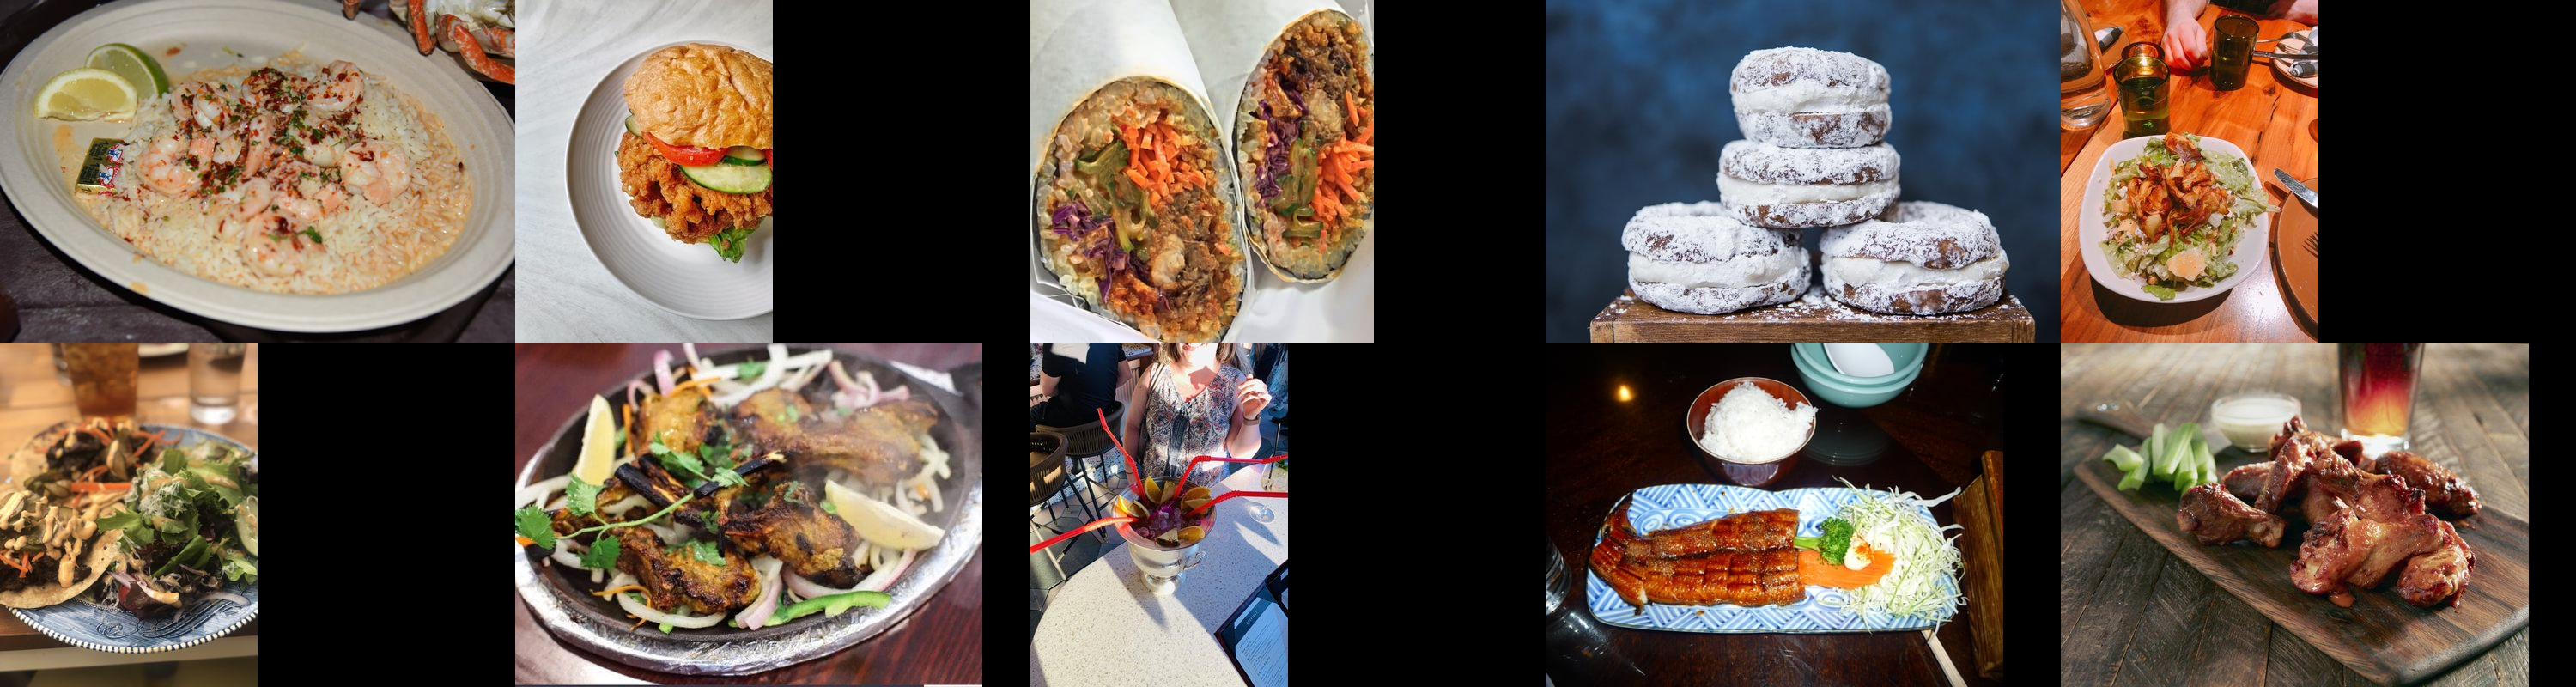

In [9]:
from PIL import Image

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


images = []

# show 10 sample photos
for img in all_photos[:10]:
    img_id = img['photo_id']

    images.append(Image.open(os.path.join(photo_path, img_id + ".jpg")))

grid = image_grid(images, cols=5)
display(grid)

In [14]:
# @title create smaller "dev" dataset and complete "prod" dataset
import random
import torch
import os
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from pathlib import Path


loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

class CaptionedImageDataset(Dataset):
    def __init__(self, imgs, text, processor):
        self.imgs = imgs
        self.text = text
        self.processor = processor
        self.root_path = './photos/'

    def __len__(self):
        return len(self.img_text_pairs)

    def __getitem__(self, idx):
        img, text = self.imgs[idx], self.text[idx]
        image = self.preprocess(images=img)
        caption = self.preprocess(text=text, padding=True)
        return image, caption


# pick 20% as an experimental dataset: ~10k food images
num_to_pick = round(len(all_photos) * 0.01)
dev_photos = random.sample(all_photos, num_to_pick)
    
# init processors
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# TODO: change to all_photos for final testing
# img_text = [(img['photo_id'] + ".jpg", img['caption']) for img in dev_photos]
images = [Image.open(os.path.join(photo_path, img['photo_id'] + ".jpg")).convert("RGB") for img in dev_photos]
captions = [img['caption'] for img in dev_photos]
dataset = CaptionedImageDataset(images, captions, processor)

# inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


num_epochs = 10


for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch 
        
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

Unused or unrecognized kwargs: padding.


: 

In [5]:

# Prepare the dataset and dataloader
# dataset = CaptionedImageDataset(img_text_pairs, processor)
dataloader = DataLoader(dataset, batch_size=2) # shuffle=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)





# TODO: configure number of epochs for final report
for epoch in range(1):  
    for batch in dataloader:
        # Move batch to device
        inputs = {k: v.to(device) for k, v in batch.items()}
        print(inputs)
        # Forward pass
        outputs = model(**inputs)
        logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text
        loss = outputs.loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

# Save the fine-tuned model
model.save_pretrained("model/dev_model")
processor.save_pretrained("model/dev_processor")

NameError: name 'dataset' is not defined